## Implement and simulate RL model 

This notebook implements a basic RL model with a n-armed bandit task. 
The simulation should produce results that mimic the behavioral data including:

* trial: trial number in block
* stimulus: stimulus presented for this trial (1:x, x = set size)
* key_press: action for the trial (0 = J, 1 = K, 2 = L)
* key_answer: correct action for the trial (0 = J, 1 = K, 2 = L)
* correct: whether response was corect
* set_size: set size of this block
* set: image folder used for this block
* img_num: image file used for this trial's stimulus
* iteration: how many times this stimulus has been seen so far
* delay: how many trials since last presentation of this stimulus
* reward_history: how many correct responses for this stimulus since block start

This should also be able to look at the affects of various hyperparameters in the model including: 

* alpha (float between 0 and 1): learning rate
* beta (int): temperature
* epsilon (float between 0 and 1): noise
* phi (float between 0 and 1): decay
* pers (float between 0 and 1): perseveration, values closer to 1 have complete neglect of 
* negative feedback
* values near 0 represent equal learning from positive and negative learning


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import random

In [1]:
class simulate_RL6():
    def __init__(self, alpha, beta, epsilon, phi, pers, T, actions,reward):
        self.alpha = alpha
        self.pers = pers
        self.neg_alpha = (1-self.pers)*self.alpha
        self.beta = beta
        self.epsilon = epsilon
        self.phi = phi
        self.pers = pers
        self.T = T
        self.correct = []
        self.key_answer = []
        self.stimulus = []
        self.reward = reward
        self.actions = actions
        self.Q = np.zeros((len(self.reward.keys()), self.actions))
    def fit(self):
        """This function will train the model
        """
        for i in range(0, self.T):
            
 
            set_size = len(self.reward.keys())
            s = np.random.randint(0, set_size)
            self.stimulus.append(s)
            
            p = np.exp(self.beta * self.Q[s, :])
            p= p/np.sum(p)
            p = (1-self.epsilon)*p + self.epsilon*(1/self.actions)
            a
            a = random.choices(list(range(0, self.actions)), weights=p)[0]
            self.key_answer.append(a)
            correct = self.reward[s]
            if correct == a:
                r = 1
            else:
                r=0

            Q0 = self.Q[s, a].copy()
            if r==0:
                self.Q[s,a] = self.Q[s,a] + self.neg_alpha*(r-self.Q[s,a])
               
            else:
                self.Q[s, a] = self.Q[s, a] + self.alpha*(r-self.Q[s, a])
            self.Q[s,a] = self.Q[s, a] + self.phi*(Q0-self.Q[s, a])
            self.correct.append(r)
        
    def get_delay(self):
        if len(self.stimulus)==0:
            raise NameError("model not yet fit, please fit model")
        else:
            self.delay = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.delay.append(0)
                else:
                    biggest_idx = np.max(np.where(idx < j)[0])
                    self.delay.append(j-idx[biggest_idx])
        
    def get_iteration(self):
        if len(self.correct) == 0:
            print("model not yet fit please fit model")
        else:
            self.iteration = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.iteration.append(0)
                else:
                    self.iteration.append(len(np.where(idx<j)[0]))
    def get_reward_history():
        if len(self.correct)==0:
            print("model not yet fit, please fit model")
        else:
            pass
        
    

In [ ]:
class simulate_RLWM():
    """ This class includes the function for fitting a simulation of the RLWM task.
    It can also be used to train the model with the behavioral data. 
    
    Args:
    
    Alpha (float): learning rate bounded from 0 to 1
    K (int): working memory capacity
    prior (): working memory prior weight
    beta (int): inverse temperature average value is 5 . Fixed to 100
    epsilon (float): noise bounded from 0 to 1
    phi (float): decay bounded from 0 to 1
    pers (float): neglect of negative values bounded from 0 to 1
    T (int): number of trials per block
    actions (int): number of possible responses
    reward (dict): keys are the stimulus, values are the correct action response
    
    """
    def __init__(self, alpha, K, prior, beta, epsilon, phi, pers, T, actions,reward):
        self.alpha = alpha
        self.pers = pers
        self.neg_alpha = (1-self.pers)*self.alpha
        self.beta = beta
        self.epsilon = epsilon
        self.phi = phi
        self.pers = pers
        self.prior = prior
        self.T = T
        self.correct = []
        self.key_answer = []
        self.stimulus = []
        self.reward = reward
        self.actions = actions
        self.Q = np.zeros((len(self.reward.keys()), self.actions))
        self.W = np.zeros((len(self.reward.keys()), self.actions))
    def fit(self):
        """This function will train the model
        """
        for i in range(0, self.T):
            
 
            set_size = len(self.reward.keys())
            s = np.random.randint(0, set_size)
            self.stimulus.append(s)
            
            Wwm = self.prior*(np.min(1, self.K/set_size))
            
            Prl = np.exp(self.beta * self.Q[s, :])
            Prl = Prl/np.sum(Prl)
            
            Pwm = np.exp(self.betawm * self.Qwm[s, :])
            Pwm = Pwm/np.sum(Pwm)
            
            Pall = Wwm*Pwm + (1-Wwm)*Prl
            Pall = (1-self.epsilon)*Pall + self.epsilon*(1/self.actions)

            
            
            a = random.choices(list(range(0, self.actions)), weights=Pall)[0]
            self.key_answer.append(a)
            correct = self.reward[s]
            if correct == a:
                r = 1
            else:
                r=0
            Q0 = self.Q[s, a].copy()
            W0 = self.W[s, a].copy()
            if r==0:
                self.Q[s,a] = self.Q[s,a] + self.neg_alpha*(r-self.Q[s,a])
               
            else:
                self.Q[s, a] = self.Q[s, a] + self.alpha*(r-self.Q[s, a])
            
            
            self.Q[s,a] = self.Q[s, a] + self.phi*(Q0-self.Q[s, a])
            self.W[s,a] = r
            self.W[s, a] = self.W[s, a] + self.phi(W0-self.W[s, a])
            self.correct.append(r)
        
    def get_delay(self):
        if len(self.stimulus)==0:
            raise NameError("model not yet fit, please fit model")
        else:
            self.delay = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.delay.append(0)
                else:
                    biggest_idx = np.max(np.where(idx < j)[0])
                    self.delay.append(j-idx[biggest_idx])
        
    def get_iteration(self):
        if len(self.correct) == 0:
            print("model not yet fit please fit model")
        else:
            self.iteration = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.iteration.append(0)
                else:
                    self.iteration.append(len(np.where(idx<j)[0]))
    def get_reward_history():
        if len(self.correct)==0:
            print("model not yet fit, please fit model")
        else:
            pass
        

In [2]:
class simulate_RL2():
    def __init__(self, alpha, beta, T, actions,reward):
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.correct = []
        self.key_answer = []
        self.stimulus = []
        self.reward = reward
        self.actions = actions
        self.Q = np.zeros((len(self.reward.keys()), self.actions))
    def fit(self):
        """This function will train the model
        """
        for i in range(0, self.T):
            
            set_size = len(self.reward.keys())
            
            s = np.random.randint(0, set_size)
            self.stimulus.append(s)
            
            p = np.exp(self.beta * self.Q[s, :])
            p= p/np.sum(p)
            
            a = random.choices(list(range(0, self.actions)), weights=p)[0]
            self.key_answer.append(a)
            correct = self.reward[s]
            if correct == a:
                r = 1
            else:
                r=0

            self.Q[s, a] = self.Q[s, a] + self.alpha*(r-self.Q[s, a])
            self.correct.append(r)
        
    def get_delay(self):
        if len(self.stimulus)==0:
            raise NameError("model not yet fit, please fit model")
        else:
            self.delay = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.delay.append(0)
                else:
                    biggest_idx = np.max(np.where(idx < j)[0])
                    self.delay.append(j-idx[biggest_idx])
        
    def get_iteration(self):
        if len(self.correct) == 0:
            print("model not yet fit please fit model")
        else:
            self.iteration = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.iteration.append(0)
                else:
                    self.iteration.append(len(np.where(idx<j)[0]))
    def get_reward_history():
        if len(self.correct)==0:
            print("model not yet fit, please fit model")
        else:
            pass
        
    

In [5]:
alpha = 1
beta= 1
epsilon =0.1
phi=0.1
pers=0.1
T=100
actions = 3
#rewards = {0:1, 1:0}#, 2:1, 3:2, 4:2, 5:0}



# model = simulate_RL6(alpha, beta, epsilon, phi, pers, T, actions, rewards)
# model.fit()
# model.get_delay()
# model.get_iteration()

In [6]:
all_correct = dict()
all_iter = dict()
for r in [{0:1, 1:0}, {0:1, 1:0, 2:1}, {0:1, 1:0, 2:1, 3:2}, {0:1, 1:0, 2:1, 3:2, 4:2}, {0:1, 1:0, 2:1, 3:2, 4:2, 5:0}]:
    correct_x = []
    iter_x = []
    for x in range(100):
        model = simulate_RL2(alpha, beta, T, actions, r)
        model.fit()
        model.get_iteration()
        correct_x.append(model.correct)
        iter_x.append(model.iteration)
    all_correct[len(r.keys())] = correct_x
    all_iter[len(r.keys())] = iter_x

In [7]:
all_set = {}
sem_set = {}

for i in range(2, 7):
    mean_iter = []
    sem_iter = []
    for  n in range(1, 20):
        just_iter = np.where(np.concatenate(np.array(all_iter[i]))==n)[0]
        test_result = np.array([i for j, i in enumerate(np.concatenate(np.array(all_correct[i]))) if j in just_iter])
        mean_iter.append(np.mean(test_result))
        sem_iter.append(scipy.stats.sem(test_result))
    all_set[i] = mean_iter
    sem_set[i] = sem_iter
        

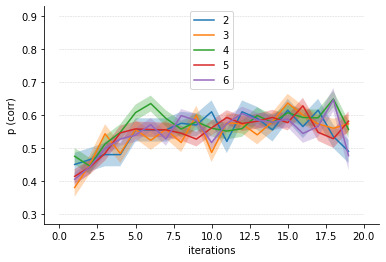

In [8]:
plt.figure()
ax = plt.subplot(111)

for i in range(2, 7):
    plt.plot(list(range(1, 20)), all_set[i], label=str(i))
    plt.fill_between(list(range(1, 20)), [i-j for i, j in zip(all_set[i], sem_set[i])], [i+j for i, j in zip(all_set[i], sem_set[i])], alpha=0.3)

for y in range(30, 100, 10):
     plt.plot([0, 8, 14, 20], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend()
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True) 

In [9]:
all_correct = dict()
all_iter = dict()
for r in [{0:1, 1:0}, {0:1, 1:0, 2:1}, {0:1, 1:0, 2:1, 3:2}, {0:1, 1:0, 2:1, 3:2, 4:2}, {0:1, 1:0, 2:1, 3:2, 4:2, 5:0}]:
    correct_x = []
    iter_x = []
    for x in range(100):
        model = simulate_RL6(alpha, beta, epsilon, phi, pers, T, actions, r)
        model.fit()
        model.get_iteration()
        correct_x.append(model.correct)
        iter_x.append(model.iteration)
    all_correct[len(r.keys())] = correct_x
    all_iter[len(r.keys())] = iter_x

In [10]:
all_set = {}
sem_set = {}

for i in range(2, 7):
    mean_iter = []
    sem_iter = []
    for  n in range(1, 20):
        just_iter = np.where(np.concatenate(np.array(all_iter[i]))==n)[0]
        test_result = np.array([i for j, i in enumerate(np.concatenate(np.array(all_correct[i]))) if j in just_iter])
        mean_iter.append(np.mean(test_result))
        sem_iter.append(scipy.stats.sem(test_result))
    all_set[i] = mean_iter
    sem_set[i] = sem_iter
        

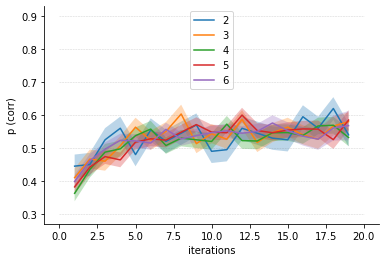

In [11]:
plt.figure()
ax = plt.subplot(111)

for i in range(2, 7):
    plt.plot(list(range(1, 20)), all_set[i], label=str(i))
    plt.fill_between(list(range(1, 20)), [i-j for i, j in zip(all_set[i], sem_set[i])], [i+j for i, j in zip(all_set[i], sem_set[i])], alpha=0.3)

for y in range(30, 100, 10):
     plt.plot([0, 8, 14, 20], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend()
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True) 

In [4]:
all_correct = dict()
all_sem = dict()
for a in range (10, 100, 20):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RL6(a/100, 0.9, 0.1, 0.1, 0.6, 100)
        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(a/100)] = correct
    all_sem[str(a/100)] = correct_sem





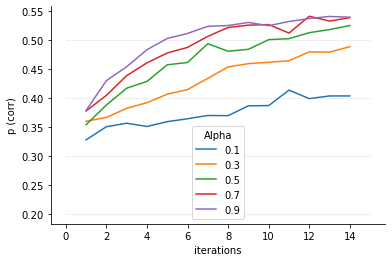

In [5]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(20, 60, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='Alpha')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [6]:
all_correct = dict()
all_sem = dict()
for b in range (10, 100, 20):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RL6(0.9, b/100, 0.1, 0.1, 0.6, 100)
        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(b/100)] = correct
    all_sem[str(b/100)] = correct_sem



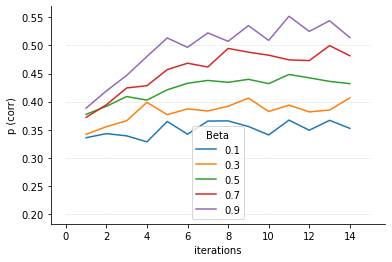

In [7]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(20, 60, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='Beta')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [8]:
all_correct = dict()
all_sem = dict()
for e in range (10, 100, 20):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RL6(0.9, 0.9, e/100, 0.1, 0.6, 100)
        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(e/100)] = correct
    all_sem[str(e/100)] = correct_sem

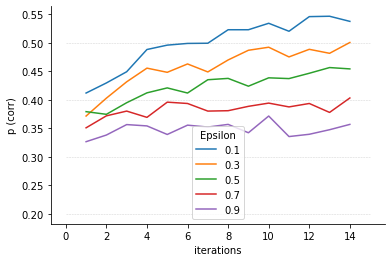

In [9]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(20, 60, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='Epsilon')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [10]:
all_correct = dict()
all_sem = dict()
for p in range (10, 100, 20):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RL6(0.9, 0.9, 0.1, p/100, 0.6, 100)
        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(p/100)] = correct
    all_sem[str(p/100)] = correct_sem

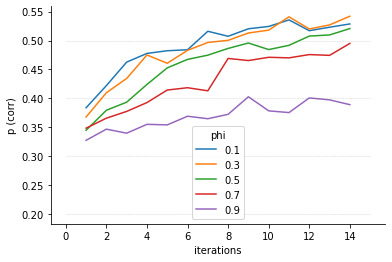

In [12]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(20, 60, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='phi')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [21]:
all_correct = dict()
all_sem = dict()
for p in range (10, 100, 20):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RL6(0.9, 0.9, 0.1, 0.1, p/100, 100)
        model.fit()
        model.get_delay()
        model.get_iteration()
        if i ==1:
            print(model.neg_alpha)

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(p/100)] = correct
    all_sem[str(p/100)] = correct_sem

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here
made it here

KeyboardInterrupt: 

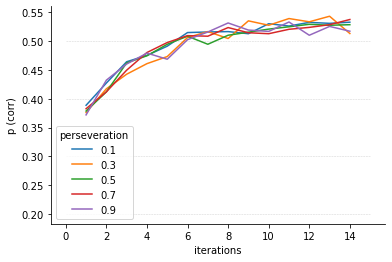

In [17]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(20, 60, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='perseveration')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

0.08999999999999998